Plot time series and extract modes from a text file:

In [44]:
### Libraries ###

import os, sys
from git import Repo
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks  
from scipy.ndimage import gaussian_filter1d

In [58]:
#### Functions ####

def get_info(thorn,quantity, folder,t0,coordinate="x"):
        print("Looking for files in the folder: {}".format(folder))
        os.chdir(folder)
        filex = f"{thorn}-{quantity}.{coordinate}.asc"
        print("Opening file: {}.....".format(filex))
        datax = np.loadtxt(filex, comments='#')
        print("Reading file....")
        
        # Number of iterations
        it = np.unique(datax[:, 0])
        it_n = len(it)
        print("Number of iterations:", it_n)
        
        # Time values
        t = np.unique(datax[:, 8])
        # X values
        if coordinate == "x": 
           x_p = np.unique(datax[:, 9])
        if coordinate == "y": 
           x_p = np.unique(datax[:, 10])
        if coordinate == "z": 
           x_p = np.unique(datax[:, 11])
         
        # Refinement levels	
        rl = np.unique(datax[:, 2])
        print('N points in x_p:')
        print(len(x_p))
        rl_n = len(rl)
        print("Total number of refinement levels:", rl_n)

        if t0<t[-1] and t0!=0:
            t=t[t>t0]
            t_n = len(t)
            print("Number of different time values:", t_n)

        # Points
            x_p_n = len(x_p)
            print("Total number of points:", x_p_n)


            points_per_rl = []
            rl_max_point = []
            for i in range(rl_n):
                x_in_rl = np.unique(datax[datax[:, 2] == rl[i], 9])
                points_in_rl = len(x_in_rl)
                print("Number of points in refinement level", i, ":", points_in_rl)
                rl_max_point.append(np.max(x_in_rl))
                points_per_rl.append(points_in_rl)
       # rl_max_point.append(0.0)
        
        return t,x_p,rl,rl_n,datax

def fx_timeseries(t,x_p,datax,ixd, coordinate="x"):     #index value of x as input
    #create output lists
    print(os.getcwd())
    t_n = len(t)
    time_values = []
    f_xt_values = []
    #print(f"Calculating timeseries for {coordinate} = {x_p[ixd]}")
    print(f"Starting at  t = {t[0]}")
 # create filter for time steps
    for j in range(t_n): 
        t_index = datax[:,8] == t[j]
# get data  as t,coordinate,f(t,coordinate) 
        if coordinate == "x": 
          f_x_ti = np.vstack(  (datax[t_index,8],  datax[t_index,9]  , datax[t_index,12]  ))
        if coordinate == "y": 
          f_x_ti = np.vstack(  (datax[t_index,8],  datax[t_index,10]  , datax[t_index,12]  ))
        if coordinate == "z": 
          f_x_ti = np.vstack(  (datax[t_index,8],  datax[t_index,11]  , datax[t_index,12]  ))
#now x=f_x_ti[0][:] and f(x)=f_x_ti[1][:]
 #create filter for space points
        if ixd==0:
           x_index = f_x_ti[1][:] == 0.0
        else:
           x_index = f_x_ti[1][:] == x_p[ixd]

 # save t, x and f(x,t) in a list (use lists to improve efficiency when extending)
        tj = (f_x_ti[0][x_index]).tolist()
        f_xi_tj = (f_x_ti[2][x_index]).tolist()

 #append values
        time_values.extend(tj)
        f_xt_values.extend(f_xi_tj)
        if(j==np.round(1/8*t_n) or j==np.round(1/4*t_n)) or j==np.round(3/8*t_n) or  j==np.round(1/2*t_n) or j==np.round(5/8*t_n) or j==np.round(3/4*t_n) or j==np.round(7/8*t_n):
                print("Progress: {} %".format(j/t_n *100))
    print("Done...!")
    return time_values,f_xt_values

def get_1d_slice(tk1, xk1, datax, itd, coordinate):

    #print(f"Getting 1d-{coordinate} slice at t = {tk1[itd]}")

    t_index = datax[:,8] == tk1[itd] # get all values at fixed time t_i = tk1[itd]

       # get data  as t,coordinate,f(t,coordinate) 
    if coordinate == "x": 
       f_x_ti = np.vstack(  (datax[t_index,8],  datax[t_index,9]  , datax[t_index,12]  ))
    if coordinate == "y": 
       f_x_ti = np.vstack(  (datax[t_index,8],  datax[t_index,10]  , datax[t_index,12]  ))
    if coordinate == "z": 
       f_x_ti = np.vstack(  (datax[t_index,8],  datax[t_index,11]  , datax[t_index,12]  ))

       # split into t_i, x_j, f(x_j,t_i) 
    tj = (f_x_ti[0]).tolist()    # t_i should be all the same
    xj = (f_x_ti[1]).tolist()    # array of {x,y,z} values
    f_xi_tj = (f_x_ti[2]).tolist()

    # Convert lists back to numpy arrays for sorting
    xj = np.array(xj)
    f_xi_tj = np.array(f_xi_tj)
    # Sort the arrays based on xj
    sorted_indices = np.argsort(xj)
    # Reorder both xj and f_xi_tj based on sorted indices
    xj_sorted = xj[sorted_indices]
    f_xi_tj_sorted = f_xi_tj[sorted_indices]

    return xj_sorted, f_xi_tj_sorted

def push_to_github(repo_path, commit_message):
    try:
        # Initialize the repo object
        repo = Repo(repo_path)
        
        # Stage all changes (or specify files like output_dir + "*.png")
        repo.git.add(all=True)
        
        # Commit
        now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        full_message = f"{commit_message} - {now}"
        repo.index.commit(full_message)
        
        # Push
        origin = repo.remote(name='origin')
        origin.push(refspec='main:main')
        
        print("Successfully pushed to GitHub!")
    except Exception as e:
        print(f"Error pushing to GitHub: {e}")

def fourier_transform(time_ms, rho, n_freq=3000):


    # Convert to numpy arrays
    t = np.asarray(time_ms)
    rho = np.asarray(rho)

    # Sort by time
    idx = np.argsort(t)
    t = t[idx]
    rho = rho[idx]

    # Remove duplicate time stamps (ESSENTIAL)
    unique_mask = np.diff(t, prepend=t[0] - 1.0) > 0
    t = t[unique_mask]
    rho = rho[unique_mask]

    # Time differences
    dt_all = np.diff(t)
    dt_min = np.min(dt_all[dt_all > 0])

    # Total duration (ms)
    T = t[-1] - t[0]

    # Frequency grid in kHz (1/ms)
    f_min = 1.0 / T
    f_max = 0.5 / dt_min
    freq_kHz = np.linspace(1, 9, n_freq)

    # Trapezoidal integration weights (ms)
    dt = np.zeros_like(t)
    dt[1:-1] = 0.5 * (t[2:] - t[:-2])
    dt[0] = t[1] - t[0]
    dt[-1] = t[-1] - t[-2]

    # Fourier transform (integral definition)
    rho_tilde = np.array([
        np.sum(rho * np.exp(-2j * np.pi * f * t) * dt)
        for f in freq_kHz
    ])

    power = np.abs(rho_tilde)**2

    return freq_kHz, power

def detect_star_surface(folder, filename="hydrobase-rho.x.asc", rho_floor=1e-10, time_col=8, x_col=9, rho_col=12, verbose=True):

    if verbose:
        print(f"Looking for files in the folder: {folder}")

    # Preserve caller's working directory
    cwd = os.getcwd()
    try:
        os.chdir(folder)

        if verbose:
            print(f"Opening file: {filename}.....")

        data = np.loadtxt(filename, comments='#')

    finally:
        os.chdir(cwd)

    if verbose:
        print("Reading file....")

    # --- pick initial time slice ---
    t0 = np.min(data[:, time_col])
    mask_t0 = data[:, time_col] == t0
    data_t0 = data[mask_t0]

    # --- extract x and rho ---
    x = data_t0[:, x_col]
    rho = data_t0[:, rho_col]

    # --- remove atmosphere / vacuum ---
    mask_star = rho > rho_floor
    x_star = x[mask_star]
    rho_star = rho[mask_star]  # kept for consistency / future use

    # --- unique spatial points define ixd ---
    x_p = np.unique(x_star)
    x_p.sort()

    N_ixd = len(x_p)
    surface_ixd = N_ixd - 1
    surface_x = x_p[-1]

    if verbose:
        print(f"Number of valid points: {N_ixd}")
        print(f"Physical Surface detected at x ≈ {surface_x:.4f}")
        print(f"surface index: {surface_ixd}")

    return x_p, surface_ixd, surface_x

def load_time_series(file_path):
    t_s_all = []
    rho_all = []
    with open(file_path, "r") as f:
        lines = f.readlines()

    # Process two lines at a time
    for k in range(0, len(lines), 2):
        t_s = np.fromstring(lines[k], sep=" ") ##devide by 203 for lean bssn
        rho = np.fromstring(lines[k+1], sep=" ")

        t_s_all.append(t_s)
        rho_all.append(rho)

    # Convert to object arrays (ragged arrays)
    t_s_all = np.array(t_s_all, dtype=object)
    rho_all = np.array(rho_all, dtype=object)

    print("len(t_s_all): ", len(t_s_all))
    print("len(rho_all): ", len(rho_all))
    return np.array(t_s_all), np.array(rho_all)

#### Directories ####
output_dir = "/home/hsolanki/Programs/My-Work/output/"

adm = "/home/hsolanki/simulations/Pol_sim/output-0000/tov_ET"
lean_low = "/home/hsolanki/simulations/lean_bssn/output-0001/tov_ET"
lean_mid = "/home/hsolanki/simulations/lean_bssn_mid/output-0000/tov_ET"
lean_high = "/home/hsolanki/simulations/lean_high/output-0000/tov_ET"
lean_ch = "/home/hsolanki/simulations/lean_ch/output-0000/tov_ET"

file_path = output_dir + "rho_timeseries_lean_low.txt"
file_path_1 = output_dir + "rho_timeseries_lean_mid.txt"
file_path_2 = output_dir + "rho_timeseries_lean_high.txt"
file_path_adm = output_dir + "rho_timeseries_P.txt"
file_velocity = output_dir + "vel_timeseries_P.txt"
file_lean_ch = output_dir + "rho_timeseries_lean_ch.txt"
file_lean_2 = output_dir + "rho_timeseries_lean_2.txt"
file_l_b_1_0002 = output_dir + "rho_timeseries_l_b_1_0002.txt"

Looking for files in the folder: /home/hsolanki/simulations/lean_ch/output-0000/tov_ET
Opening file: hydrobase-vel.x.asc.....
Reading file....
Number of iterations: 4667
N points in x_p:
129
Total number of refinement levels: 2


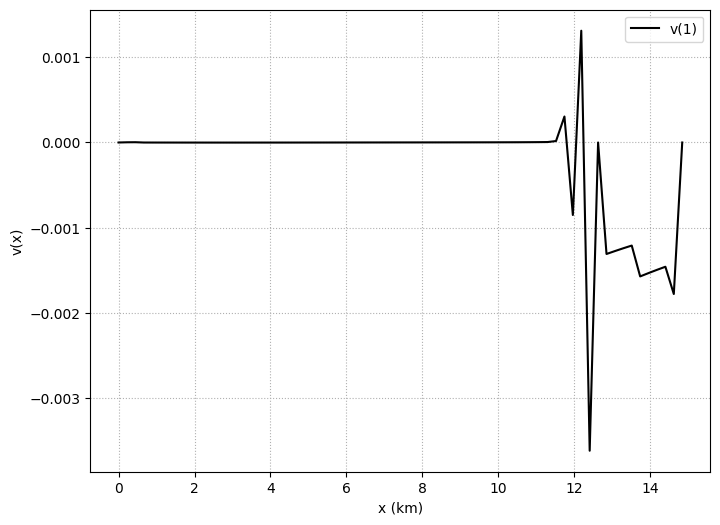

In [59]:
###### Density and Lapse 1D Slice ########

t_p,x_p_p,rl_p,rl_n_p,datax_p = get_info("hydrobase","vel",lean_ch,0.0,"x")
index = 1
xj_sorted_1, func = get_1d_slice(t_p, x_p_p, datax_p, index, "x")

# time, fxt = fx_timeseries(t_p, x_p_p,datax_p, 0.0, "x")  # rho timeseries at x_p[index]
# time = np.array(time)/203  # convert to ms

# rho = rho/rho[0]  # normalize density

xj_sorted_1 = xj_sorted_1 * 1.477  # convert to km

idx = np.argmax(xj_sorted_1 >= 15)
xj_sorted_1 = xj_sorted_1[:idx]
func = func[:idx]

plt.figure(figsize=(8,6))

plt.plot(xj_sorted_1, func, color="black", linewidth=1.5, label=f"v({index})")

plt.xlabel("x (km)")
plt.ylabel(r"v(x)")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()

In [61]:
# Detect star surface to get x_p
x_p_l, surface_ixd_l, surface_x_l = detect_star_surface(lean_low, filename="hydrobase-rho.x.asc") 
x_p_m, surface_ixd_m, surface_x_m = detect_star_surface(lean_mid, filename="hydrobase-rho.x.asc") 
x_p_h, surface_ixd_h, surface_x_h = detect_star_surface(lean_high, filename="hydrobase-rho.x.asc") 
x_p_ch, surface_ixd_ch, surface_x_ch = detect_star_surface(lean_ch, filename="hydrobase-rho.x.asc")
x_P_P, surface_ixd_p, surface_x_p = detect_star_surface(adm, filename="hydrobase-rho.x.asc") 

t_s_all_l, rho_all_l = load_time_series(file_path)
t_s_all_m, rho_all_m = load_time_series(file_path_1)
t_s_all_h, rho_all_h = load_time_series(file_path_2)
# t_s_all_v, v_all = load_time_series(file_velocity)
t_s_all_P, rho_all_P = load_time_series(file_path_adm)
t_s_all_ch, rho_all_ch = load_time_series(file_lean_ch)
t_s_all_l_b_1_0002, rho_all_l_b_1_0002 = load_time_series(file_l_b_1_0002)
t_s_all_lean_2, rho_all_lean_2 = load_time_series(file_lean_2)

t_s_all_l = t_s_all_l / 203  # convert to ms
t_s_all_m = t_s_all_m / 203  # convert to ms
t_s_all_h = t_s_all_h / 203  # convert to ms
# t_s_all_v = t_s_all_v / 203  # convert to ms
t_s_all_ch = t_s_all_ch / 203  # convert to ms
t_s_all_l_b_1_0002 = t_s_all_l_b_1_0002 / 203  # convert to ms
t_s_all_lean_2 = t_s_all_lean_2 / 203  # convert to ms


#t_s_all_P = t_s_all_P / 203  # convert to ms

Looking for files in the folder: /home/hsolanki/simulations/lean_bssn/output-0001/tov_ET
Opening file: hydrobase-rho.x.asc.....
Reading file....
Number of valid points: 23
Physical Surface detected at x ≈ 17.5000
surface index: 22
Looking for files in the folder: /home/hsolanki/simulations/lean_bssn_mid/output-0000/tov_ET
Opening file: hydrobase-rho.x.asc.....
Reading file....
Number of valid points: 39
Physical Surface detected at x ≈ 14.7500
surface index: 38
Looking for files in the folder: /home/hsolanki/simulations/lean_high/output-0000/tov_ET
Opening file: hydrobase-rho.x.asc.....
Reading file....
Number of valid points: 61
Physical Surface detected at x ≈ 13.6500
surface index: 60
Looking for files in the folder: /home/hsolanki/simulations/lean_ch/output-0000/tov_ET
Opening file: hydrobase-rho.x.asc.....
Reading file....
Number of valid points: 61
Physical Surface detected at x ≈ 13.6500
surface index: 60
Looking for files in the folder: /home/hsolanki/simulations/Pol_sim/output

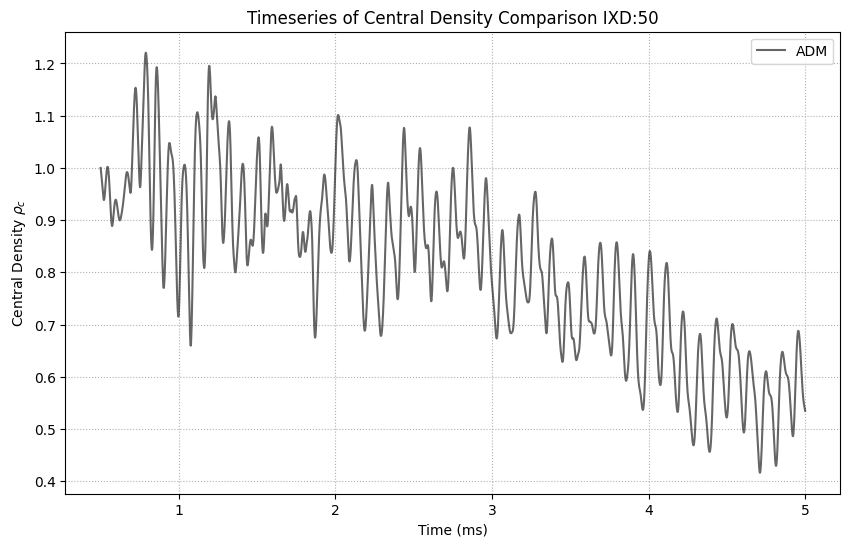

In [69]:
### Time_series Check ###
ik = 50

# t_l = t_s_all_l[ik]
# rho_l = rho_all_l[ik]

# t_m = t_s_all_m[ik]
# rho_m = rho_all_m[ik]

# t_h = t_s_all_h[ik]
# rho_h = rho_all_h[ik]

# t_b = t_s_all_l_b_1_0002[ik]
# rho_b = rho_all_l_b_1_0002[ik]

# t_l_2 = t_s_all_lean_2[ik]
# rho_l_2 = rho_all_lean_2[ik]

# t_v = t_s_all_v[ik]
# v = v_all[ik]

# t_ch = t_s_all_ch[ik]
# rho_ch = rho_all_ch[ik]

# t_adm = t_s_all_P[ik]
# rho_adm = rho_all_P[ik]

t_adm = t_s_all_P[ik]
rho_adm = rho_all_P[ik]


# lim_l = (t_l >= 0.5) & (t_l <= 5)
# lim_m = (t_m >= 0.5) & (t_m <= 5)
# lim_h = (t_h >= 0.5) & (t_h <= 5)
# lim_b = (t_b >= 0.5) & (t_b <= 5)
# lim_l_2 = (t_l_2 >= 0.5) & (t_l_2 <= 5)
# lim_ch = (t_ch >= 0.5) & (t_ch <= 5)

# lim_v = (t_v >= 0.5) & (t_v <= 5)

lim_adm = (t_adm >= 0.5) & (t_adm <= 5)

# t_l = t_l[lim_l]
# rho_l = rho_l[lim_l]
# rho_l = rho_l/rho_l[0]  # normalize density

# t_m = t_m[lim_m]
# rho_m = rho_m[lim_m]
# rho_m = rho_m/rho_m[0]  # normalize density

# t_h = t_h[lim_h]
# rho_h = rho_h[lim_h]
# rho_h = rho_h/rho_h[0]  # normalize density

# t_v = t_v[lim_v]
# v = v[lim_v]

# t_ch = t_ch[lim_ch]
# rho_ch = rho_ch[lim_ch]
# rho_ch = rho_ch/rho_ch[0]  # normalize density

# t_b = t_b[lim_b]
# rho_b = rho_b[lim_b]
# rho_b = rho_b/rho_b[0]  # normalize density

# t_l_2 = t_l_2[lim_l_2]
# rho_l_2 = rho_l_2[lim_l_2]
# rho_l_2 = rho_l_2/rho_l_2[0]  # normalize density

t_adm = t_adm[lim_adm]
rho_adm = rho_adm[lim_adm]
rho_adm = rho_adm/rho_adm[0]  # normalize density


plt.figure(figsize=(10,6))
# plt.plot(t_l, rho_l, label="LeanBSSN_low", color="blue", alpha=0.6)
# plt.plot(t_m, rho_m, label="LeanBSSN_mid", color="green", alpha=0.6)
# plt.plot(t_h, rho_h, label="LeanBSSN_high", color="red", alpha=0.6)
# plt.plot(t_ch, rho_ch, label="LeanBSSN_ch", color="orange", alpha=0.6)  
# plt.plot(t_b, rho_b, label="LeanBSSN_beta_0.5", color="purple", alpha=0.6)
# plt.plot(t_l_2, rho_l_2, label="LeanBSSN_KO", color="brown", alpha=0.6)
plt.plot(t_adm, rho_adm, label="ADM", color="black", alpha=0.6) 
plt.xlabel("Time (ms)")
plt.ylabel(r"Central Density $\rho_c$")
plt.title(f"Timeseries of Central Density Comparison IXD:{ik}")
plt.grid(True, linestyle=":")
plt.legend()
plt.show()
#plt.savefig(output_dir + "time_series_comparision.png", dpi=300)

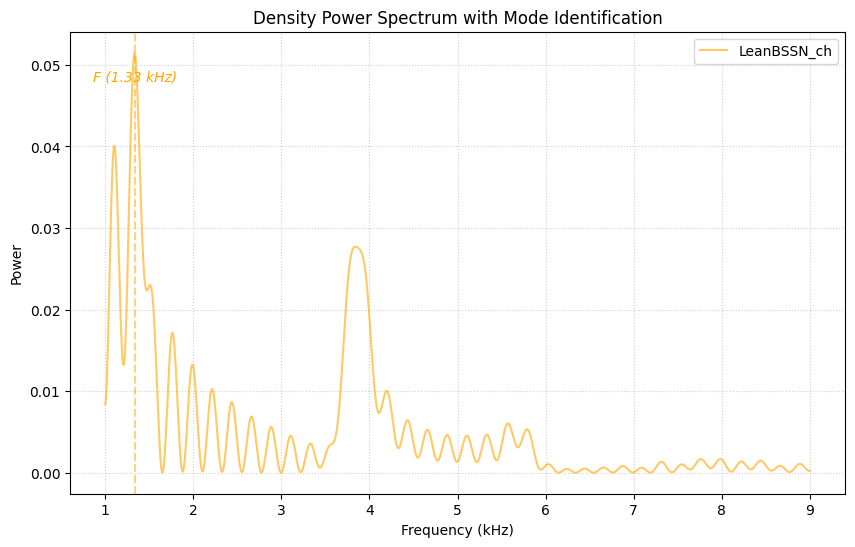

In [46]:
#### Mode Extraction ####

# freq_l, power_l = fourier_transform(t_l, rho_l)
# freq_m, power_m = fourier_transform(t_m, rho_m)
# freq_h, power_h = fourier_transform(t_h, rho_h)
freq_ch, power_ch = fourier_transform(t_ch, rho_ch)
#freq_adm, power_adm = fourier_transform(t_adm, rho_adm)



# peaks_l, properties = find_peaks(
#     power_l,
#     height=np.max(power_l) * 0.07,
#     prominence=np.percentile(power_l, 95) * 0.15,
#     width=6,
# )

# peaks_m, properties = find_peaks(
#     power_m,
#     height=np.max(power_m) * 0.07,
#     prominence=np.percentile(power_m, 95) * 0.35,
#     width=8,
# )

# peaks_h, properties = find_peaks(
#     power_h,
#     height=np.max(power_h) * 0.07,
#     prominence=np.percentile(power_h, 95) * 0.35,
#     width=8,
# )

peaks_ch, properties = find_peaks(
    power_ch,
    height=np.max(power_ch) * 0.85,
    prominence=np.percentile(power_ch, 95) * 0.35,
    width=8,
)

# F_c_l = freq_l[peaks_l[0]]  # Frequency of fundamental mode in kHz
# F_c_m = freq_m[peaks_m[0]]  # Frequency of fundamental mode in kHz
# F_c_h = freq_h[peaks_h[0]]  # Frequency of fundamental mode in kHz
F_c_h = freq_ch[peaks_ch[0]]  # Frequency of fundamental mode in kHz

labels = ["F"]

# --- Plotting the Raw Comparison ---
plt.figure(figsize=(10, 6))

# --- plot PSDs ---
# plt.plot(freq_l, power_l, alpha=0.6, color = "purple", label="LeanBSSN_low")
# plt.plot(freq_m, power_m, alpha=0.6, color = "blue", label="LeanBSSN_mid")
# plt.plot(freq_h, power_h, alpha=0.6, color = "green", label="LeanBSSN_high")
plt.plot(freq_ch, power_ch, alpha=0.6, color = "orange", label="LeanBSSN_ch")
# --- package peak information ---
spectra = [
    # {
    #     "freq": freq_l,
    #     "power": power_l,
    #     "peaks": peaks_l,
    #     "labels": labels,
    #     "color": "purple",
    #     "name": "LeanBSSN",
    #     "yoffset": 10
    # },
    # {
    #     "freq": freq_m,
    #     "power": power_m,
    #     "peaks": peaks_m,
    #     "labels": labels,
    #     "color": "blue",
    #     "name": "LeanBSSN_mid",
    #     "yoffset": 0
    # },
    # {
    #     "freq": freq_h,
    #     "power": power_h,
    #     "peaks": peaks_h,
    #     "labels": labels,
    #     "color": "green",
    #     "name": "LeanBSSN_high",
    #     "yoffset": -20
    # },
    {
        "freq": freq_ch,
        "power": power_ch,
        "peaks": peaks_ch,
        "labels": labels,
        "color": "orange",
        "name": "LeanBSSN_ch",
        "yoffset": -20
    }
]

# --- annotate peaks ---
for spec in spectra:
    for i, peak_idx in enumerate(spec["peaks"][:len(spec["labels"])]):
        x = spec["freq"][peak_idx]
        y = spec["power"][peak_idx]

        plt.axvline(
            x=x,
            color=spec["color"],
            linestyle="--",
            alpha=0.5
        )

        plt.annotate(
            f"{spec['labels'][i]} ({x:.2f} kHz)",
            xy=(x, y),
            xytext=(0, spec["yoffset"]),
            textcoords="offset points",
            ha="center",
            fontstyle="italic",
            color=spec["color"]
        )

plt.xlabel("Frequency (kHz)")
plt.ylabel("Power")
plt.title("Density Power Spectrum with Mode Identification")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
#plt.savefig(output_dir+"lean_psd_beta_1.png")
plt.show()


Looking for files in the folder: /home/hsolanki/simulations/Pol_sim/output-0000/tov_ET
Opening file: hydrobase-rho.x.asc.....
Reading file....
Number of valid points: 61
Physical Surface detected at x ≈ 13.6500
surface index: 60
Point 0: F_mode = 1.4294764921640546 kHz
1: 6090 → 2: 3045 after removing duplicates
Point 1: F_mode = 1.4294764921640546 kHz
1: 3045 → 2: 3045 after removing duplicates
Point 2: F_mode = 1.4294764921640546 kHz
1: 6090 → 2: 3045 after removing duplicates
Point 3: F_mode = 1.4294764921640546 kHz
1: 3045 → 2: 3045 after removing duplicates
Point 4: F_mode = 1.4294764921640546 kHz
1: 6090 → 2: 3045 after removing duplicates
Point 5: F_mode = 1.4294764921640546 kHz
1: 3045 → 2: 3045 after removing duplicates
Point 6: F_mode = 1.4294764921640546 kHz
1: 6090 → 2: 3045 after removing duplicates
Point 7: F_mode = 1.4294764921640546 kHz
1: 3045 → 2: 3045 after removing duplicates
Point 8: F_mode = 1.4294764921640546 kHz
1: 6090 → 2: 3045 after removing duplicates
Point 

Text(0, 0.5, '$\\tilde{\\rho}_F(r)$')

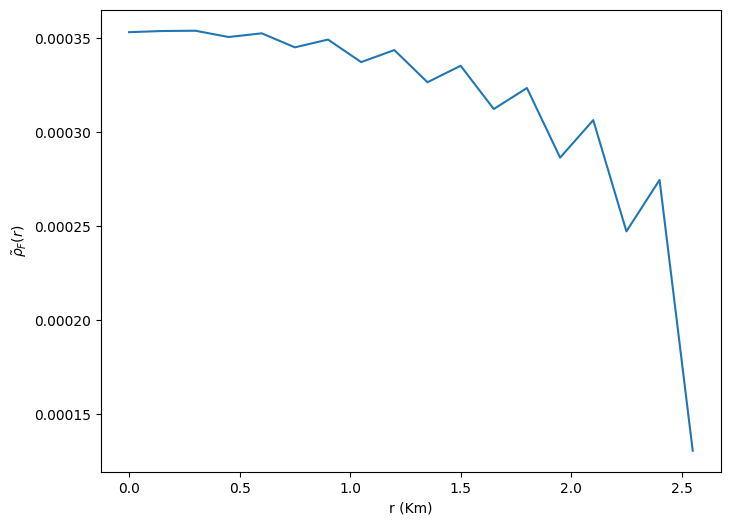

In [112]:
### Eigenfunction Extraction ###

    #Detect star surface to get x_p
x_p, surface_ixd_l, surface_x = detect_star_surface(adm, filename="hydrobase-rho.x.asc") 


F_amp_complex = []
F_freq = []

for i in range(0, 18):

    t_s = t_s_all_ch[i]
    rho = rho_all_ch[i]
    lim = (t_s >= 0.5) & (t_s <= 5)
    t_s = t_s[lim]
    rho = rho[lim]

    #### FFT ####

    freq, power = fourier_transform(t_s, rho)
    peaks, properties = find_peaks(
        power,
        height=np.max(power) * 0.85,
        prominence=np.percentile(power, 95) * 0.35,
        width=8,
    )                                # suppress narrow noise spikes 3.5

    f_F = freq[peaks[0]]  # Frequency of fundamental mode in kHz
    F_freq.append(f_F)
    print(f"Point {i}: F_mode = {f_F} kHz")
    #f_F = F_c_h

    # Remove duplicate / non-increasing times
    unique_mask = np.diff(t_s, prepend=t_s[0] - 1.0) > 0

    t = t_s[unique_mask]
    rho = rho[unique_mask]

    print(f"1: {len(t_s)} → 2: {len(t)} after removing duplicates")

    # Trapezoidal weights
    dt = np.zeros_like(t)
    dt[1:-1] = 0.5 * (t[2:] - t[:-2])
    dt[0] =  t[1] - t[0]
    dt[-1] = t[-1] - t[-2]

    # Projection onto F-mode
    rho_tilde_F = np.sum(
        rho * np.exp(-2j * np.pi * f_F * t) * dt
    )

    F_amp_complex.append(rho_tilde_F)
    #print(f"amp_F = {abs(rho_tilde_F)}")

F_amp_complex = np.array(F_amp_complex)


eig = np.real(F_amp_complex)


# Radius
r = x_p[:len(eig)]

# Plot
plt.figure(figsize=(8,6))
plt.plot(r,eig)
plt.xlabel("r (Km)")
plt.ylabel(r"$\tilde{\rho}_F(r)$")